In [1]:
import sys
from pyspark.sql.functions import col
from pyspark.sql import functions
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SparkSession
from pyspark.ml.linalg import Vectors
from pyspark.sql.types import *
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import folium
%matplotlib inline

In [2]:
# We create a SparkSession instance 
spark_session = SparkSession \
        .builder \
        .getOrCreate()

In [3]:
# Load dataframe Chicago Crimes.
data_frame = spark_session\
        .read\
        .options(header= True,inferSchema=True) \
        .option("delimiter", ";") \
        .format("csv") \
        .load("D:\crimeschicago.csv")

# Print Schema.
data_frame.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Case Number: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Block: string (nullable = true)
 |-- IUCR: string (nullable = true)
 |-- Primary Type: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Location Description: string (nullable = true)
 |-- Arrest: boolean (nullable = true)
 |-- Domestic: boolean (nullable = true)
 |-- Beat: integer (nullable = true)
 |-- District: integer (nullable = true)
 |-- Ward: integer (nullable = true)
 |-- Community Area: integer (nullable = true)
 |-- FBI Code: string (nullable = true)
 |-- X Coordinate: integer (nullable = true)
 |-- Y Coordinate: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Updated On: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Location: string (nullable = true)



In [4]:
#Clean dataframe
data_frame = data_frame.select('ID','Primary Type', 'Latitude','Longitude').where((col("Latitude").isNotNull()) & (col("Latitude")>40))
data_frame = data_frame.select('ID','Primary Type', 'Latitude','Longitude').where(col("Longitude").isNotNull())

In [5]:
data_frame.show()

+--------+--------------------+------------+-------------+
|      ID|        Primary Type|    Latitude|    Longitude|
+--------+--------------------+------------+-------------+
|11665567|         SEX OFFENSE|   41.708589|-87.612583094|
|11667963|OFFENSE INVOLVING...|41.940297617|-87.732066473|
|11667968|OFFENSE INVOLVING...|41.884865037|-87.755230327|
|11668309|             BATTERY|41.697609261|-87.613507612|
|11692179|             ASSAULT|41.729973132|-87.653166753|
|11690557|               THEFT|41.897499466|-87.693136644|
|11694459|               THEFT|41.686190998|-87.651918386|
|11694464|               THEFT| 41.85256088|-87.712355992|
|11676085|               THEFT|41.897596067|-87.623218373|
|11690176|OFFENSE INVOLVING...| 41.65369915|-87.602093356|
|11694262|            STALKING|41.737727691|-87.702064868|
|11692601|     CRIMINAL DAMAGE|41.945606268|-87.825523014|
|11692296|             BATTERY|41.721028724|-87.593539289|
|11691578|OFFENSE INVOLVING...| 41.75645779|-87.56511343

In [6]:
#Group for "Primary Type"
mostcrime = data_frame.groupBy("Primary Type").count().orderBy('count',ascending=False).take(1)[0]["Primary Type"]

In [7]:
new_data_frame = data_frame.where(col("Primary Type") == mostcrime)

In [8]:
# Create vector_assembler
vector_assembler = VectorAssembler(inputCols=["Latitude", "Longitude"], outputCol="features")
preparate_data_frame = vector_assembler.transform(new_data_frame)

preparate_data_frame.show(5)

+--------+------------+------------+-------------+--------------------+
|      ID|Primary Type|    Latitude|    Longitude|            features|
+--------+------------+------------+-------------+--------------------+
|11690557|       THEFT|41.897499466|-87.693136644|[41.897499466,-87...|
|11694459|       THEFT|41.686190998|-87.651918386|[41.686190998,-87...|
|11694464|       THEFT| 41.85256088|-87.712355992|[41.85256088,-87....|
|11676085|       THEFT|41.897596067|-87.623218373|[41.897596067,-87...|
|11693682|       THEFT|41.781418541|-87.608405955|[41.781418541,-87...|
+--------+------------+------------+-------------+--------------------+
only showing top 5 rows



In [9]:
# Model K-means
from pyspark.ml.clustering import KMeans

kmeans = KMeans(k=4, seed=1)  
model = kmeans.fit(preparate_data_frame.select('features'))

In [10]:
transformed = model.transform(preparate_data_frame)
transformed.show(25)

+--------+------------+------------+-------------+--------------------+----------+
|      ID|Primary Type|    Latitude|    Longitude|            features|prediction|
+--------+------------+------------+-------------+--------------------+----------+
|11690557|       THEFT|41.897499466|-87.693136644|[41.897499466,-87...|         0|
|11694459|       THEFT|41.686190998|-87.651918386|[41.686190998,-87...|         3|
|11694464|       THEFT| 41.85256088|-87.712355992|[41.85256088,-87....|         2|
|11676085|       THEFT|41.897596067|-87.623218373|[41.897596067,-87...|         0|
|11693682|       THEFT|41.781418541|-87.608405955|[41.781418541,-87...|         3|
|11694435|       THEFT|41.917671378|-87.658933611|[41.917671378,-87...|         0|
|11694436|       THEFT|41.885738286| -87.63576612|[41.885738286,-87...|         0|
|11694460|       THEFT|41.924781923|-87.761094988|[41.924781923,-87...|         1|
|11695416|       THEFT|41.745639153|-87.703493452|[41.745639153,-87...|         2|
|116

In [11]:
centers = model.clusterCenters()
print("Cluster centers: ")

for center in centers:
     print(center)

Cluster centers: 
[ 41.89699278 -87.6486483 ]
[ 41.94369066 -87.73168493]
[ 41.79943201 -87.69959283]
[ 41.7469597  -87.61296732]


In [12]:
centers[0][0]

41.89699278039636

In [13]:
#Convert to pandas
data_for_plot= transformed.select("*").toPandas()


In [14]:
data_for_plot.head()

,ID,Primary Type,Latitude,Longitude,features,prediction
0,11690557,THEFT,41.897499,-87.693137,"[41.897499466, -87.693136644]",0
1,11694459,THEFT,41.686191,-87.651918,"[41.686190998, -87.651918386]",3
2,11694464,THEFT,41.852561,-87.712356,"[41.85256088, -87.712355992]",2
3,11676085,THEFT,41.897596,-87.623218,"[41.897596067, -87.623218373]",0
4,11693682,THEFT,41.781419,-87.608406,"[41.781418541, -87.608405955]",3


In [15]:
labels = data_for_plot["prediction"]
x = data_for_plot["Latitude"]
y = data_for_plot["Longitude"]

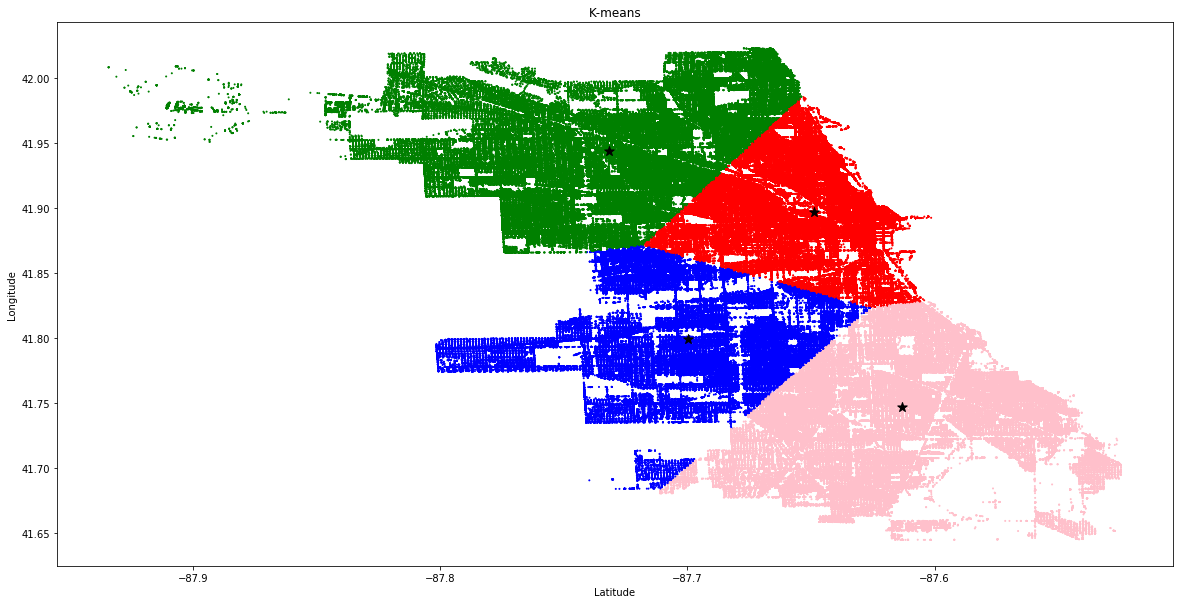

In [20]:
#Print Cluster
plt.figure(figsize=(20, 10))
colores=['red','green','blue','pink']
asignar=[]
x_center=[]
y_center=[]
for r in range(len(centers)):
    x_center.append(centers[r][0])
    y_center.append(centers[r][1])
for row in labels  :
     asignar.append(colores[row])
plt.scatter(y, x, c=asignar, s=1)
plt.scatter(y_center, x_center, marker='*', c='black', s=100)
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('K-means')
plt.show()

In [64]:
data_for_map = data_for_plot.sample(n=50)

In [65]:
#Coordinates
chicago_coordinates = (41.803671998, -87.703846021)

In [188]:
#Preparate data for print map
location = data_for_map[['Latitude', 'Longitude', 'prediction']]
locationlist = location.values.tolist()
len(locationlist)
locationlist[7]

[41.943749037, -87.719981276, 1.0]

In [189]:
#Print Map
colores={0:'red',1:'green',2:'blue',3:'pink'}
map = folium.Map(location=chicago_coordinates, zoom_start=9)
for point in range(0, len(locationlist)):
    folium.Marker(locationlist[point][0:2], popup="Cluster", icon=folium.Icon(color=colores[int(locationlist[point][2])],  icon='', prefix='fa')).add_to(map)
for loc in range(len(centers)):
    folium.Marker(centers[loc],centers[loc], icon=folium.Icon(color="black", icon='*', prefix='fa')).add_to(map)            
map
    